In [2]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
#%matplotlib notebook
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import cProfile
import pstats
import io
from pstats import SortKey

In [3]:
nifty5 = pd.read_csv('NEW_Cleaned_Nifty50_5min.csv')
nifty5['EMA']=nifty5['Close'].ewm(span=5, adjust=False).mean()

In [97]:
list(range(6,16))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
#c3['Gap'] = np.linspace(0.05,0.15,10)
#daysconsidered=min(234,1807) #offset to start for some given date
#years=[234, 468, 702, 936, 1170, 1404]

c1 = pd.DataFrame(columns=['Date', 'Number of trades'])
c1['Date'] = nifty5['Date']
c2 = pd.DataFrame(columns=['Date', 'Time','Balance','BoughtAt','SoldAt'])
c2['Date'] = nifty5['Date']
c2['Time'] = nifty5['Time']
c3 = pd.DataFrame(columns=['LastDate','MinSL','Number of trades','Maximum Drawdown','POP','Net Return','Annualized Return','RRR'])
c3['MinSL'] = list(range(0,20))
c3['Annualized Return']=0
d1=[]
d2=[]

pn=0
ln=0

def sell(i,j,tgt,sl,slp):
#         j+=1
    global pn,ln
    k=j
    for k in range(j,74):
        if nifty5['High'][i*75+k]>sl:
            ln+=1
            return k, sl
        if nifty5['Low'][i*75+k]<tgt:            
            pn+=1
            return k, tgt
    return k, nifty5['Close'][i*75+k]

for proftolossratio in list(range(6,16)):
    start=time.time()
    d1=[]
    for lastdateconsidered in [169, 403, 637, 871, 1105, 1339, 1573]:
        for ii in range(len(c3['MinSL'])):
            daysconsidered=234
            global pn,ln
            b=nifty5.Date.nunique()-lastdateconsidered
            a=b-daysconsidered
            
            c1['Number of trades']=0
            
            c2['Balance'][a*75] = round(25*nifty5['Open'][a*75],-4)
            c2['BoughtAt'] = 0
            c2['SoldAt'] = 0

            #proftolossratio=5
            slippage=1
            gap=0.05 #c3.loc[ii,'Gap'] # Gap above nifty in percentage terms

            ini=c2['Balance'][a*75]
            balance=ini
            tgt=0.0
            sl=0.0
            profit=0.0
            leverage=5
            sellflag=1
            buyflag=0
            slip=slippage/100
            gap=gap/100
            for i in range(a,b):
                n=max(1,math.floor(balance/nifty5['Open'][i*75]))
                profit=0
                k=0
                if i>a:
                    c2.at[i*75, 'Balance'] = c2.loc[i*75-1, 'Balance']
                for j in range(1,nifty5.Time.nunique()):
                    if j<k+1:
                        continue  

                    if j!=k:
                        c2.at[i*75+j, 'Balance'] = c2.loc[i*75+j-1, 'Balance']

                    if sellflag==1 and nifty5['Open'][i*75+j-1]>nifty5['EMA'][i*75+j-1] and nifty5['Close'][i*75+j-1]>nifty5['EMA'][i*75+j-1]:
                        if (min(nifty5['Open'][i*75+j-1],nifty5['Close'][i*75+j-1])-nifty5['EMA'][i*75+j-1])<gap*nifty5['Close'][i*75+j-1]:
                            if nifty5['Low'][i*75+j]<nifty5['Low'][i*75+j-1] and (nifty5['High'][i*75+j-1]-nifty5['Low'][i*75+j-1])>c3.loc[ii,'MinSL']:
                                slp=nifty5['Low'][i*75+j-1]
                                sl=nifty5['High'][i*75+j-1]
                                tgt=slp-(sl-slp)*proftolossratio
                                k, byp=sell(i,j,tgt,sl,slp)       
                                for j1 in range(j,k+1):
                                    c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
                                c1.at[i*75,'Number of trades'] += 1
                                c2.at[i*75+k,'Balance'] = c2.loc[i*75+k,'Balance']+n*(slp-byp)*leverage-nifty5['Close'][i*75+j]*slip
                                c2.at[i*75+k,'BoughtAt'] = byp
                                c2.at[i*75+j,'SoldAt'] = slp
                                continue 

                balance= c2.at[i*75+j, 'Balance']
                if balance<0: #Total Loss
                    break

            res=(balance-ini)/ini
            Roll_Max = c2['Balance'][a*75:b*75:75].cummax()
            Daily_Drawdown = c2['Balance'][a*75:b*75:75]/Roll_Max - 1.0
            Max_Daily_Drawdown = Daily_Drawdown.cummin()
            c3.at[ii,'Number of trades']=c1[c1['Number of trades']!=0]['Number of trades'].mean()
            c3.at[ii,'Maximum Drawdown']=100*min(np.array(Max_Daily_Drawdown))
            if (ln+pn)>0:
                c3.at[ii,'POP']=100*pn/(ln+pn)
            else:
                c3.at[ii,'POP']=0
            c3.at[ii,'Net Return']=res*100
            if res>0:
                c3.at[ii,'Annualized Return']=100*(pow(10,math.log(1+res,10)/(daysconsidered/234))-1)
            else:
                c3.at[ii,'Annualized Return']=0
            c3.at[ii,'LastDate']=lastdateconsidered
            c3.at[ii,'RRR']=proftolossratio
        d1.append(c3.copy())
    d2.append(d1)
    end=time.time()-start
    left=10-proftolossratio
    print('Done for RRR: {}, ETA: {:.2f} mins'.format(proftolossratio,(10-proftolossratio)*end/60))
    

In [ ]:
for i in range(10):
    for j in range(7):
        d2[i][j].to_csv('RRR '+str(i+1)+' LastDate '+str(d2[i][j]['LastDate'][0])+' .csv', index=False)

In [ ]:
l1=[]
l2=[]
l3=[]
l4=[]
for i in range(10):
    l1=[]
    l2=[]
    for j in range(7):
        l1.append(d2[i][j]['Net Return'].values.argmax())
        l2.append(d2[i][j]['Net Return'].values.max())
    l3.append(np.array(l1).mean())
    l4.append(np.array(l2).mean())

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
#fig.suptitle('For RRR of 4 and gap of 0.05')
ax[0].set_xlabel('RRR')
ax[0].set_ylabel('MinSL')
for i in range(10):
    ax[0].plot(list(range(6,16)),l3)
    ax[0].set_title("MinSL")

ax[1].set_xlabel('RRR')
ax[1].set_ylabel('Net Return')
for i in range(10):
    ax[1].plot(list(range(6,16)),l4)
    ax[1].set_title("Net Return")

#ax[0].legend()
fig.tight_layout()

In [ ]:
lnr=[]
lnrr=[]
for i in range(0,7):
    lnr.append(d1[i]['Net Return'].values.argmax())
    lnrr.append(d1[i]['Net Return'].values.max())
print(np.array(lnr).mean())
print(lnr)
print(lnrr)
print('RRR is',proftolossratio)

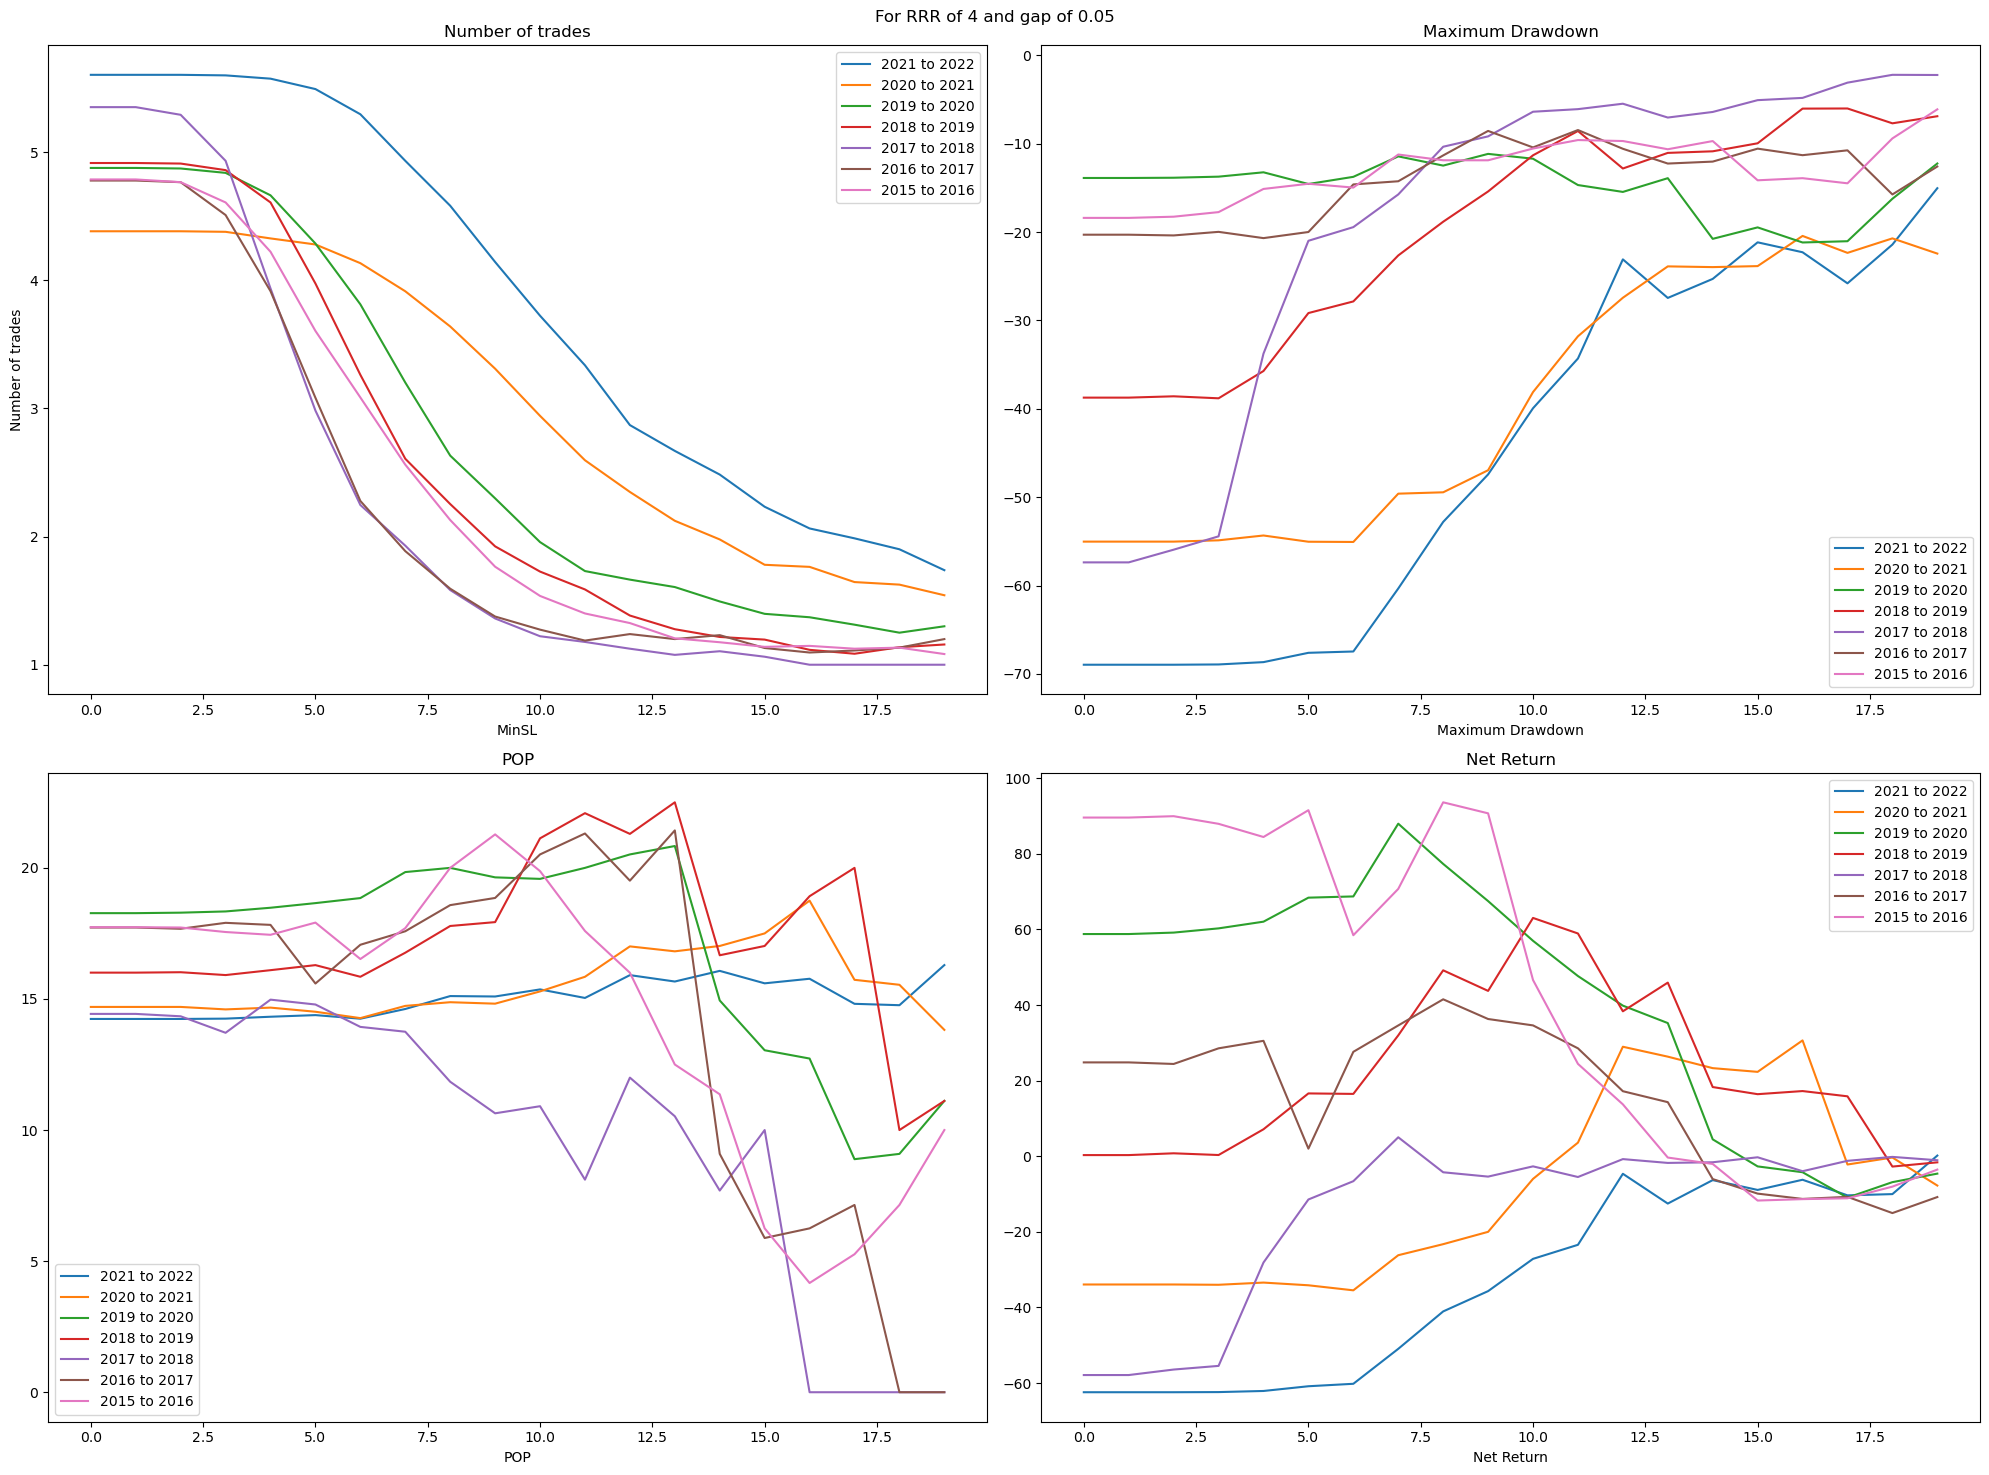

In [133]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
fig.suptitle('For RRR of 4 and gap of 0.05')
ax[0,0].set_xlabel('MinSL')
ax[0,0].set_ylabel('Number of trades')
for j in range(7):
    ax[0,0].plot(c3['MinSL'],d1[j]['Number of trades'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,0].set_title("Number of trades")

ax[0,0].legend()  
ax[0,1].set_xlabel('MinSL')
ax[0,1].set_xlabel('Maximum Drawdown')
for j in range(7):
    ax[0,1].plot(c3['MinSL'],d1[j]['Maximum Drawdown'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,1].set_title("Maximum Drawdown")
    
ax[0,1].legend()
ax[1,0].set_xlabel('MinSL')
ax[1,0].set_xlabel('POP')
for j in range(7):
    ax[1,0].plot(c3['MinSL'],d1[j]['POP'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,0].set_title("POP")
    
ax[1,0].legend()
ax[1,1].set_xlabel('MinSL')
ax[1,1].set_xlabel('Net Return')
for j in range(7):
    ax[1,1].plot(c3['MinSL'],d1[j]['Net Return'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,1].set_title("Net Return")

ax[1,1].legend()
fig.tight_layout()

In [140]:
lnr=[]
lnrr=[]
for i in range(0,7):
    lnr.append(d1[i]['Net Return'].values.argmax())
    lnrr.append(d1[i]['Net Return'].values.max())
print(np.array(lnr).mean())
print(lnr)
print(lnrr)
print('RRR is',proftolossratio)

10.714285714285714
[19, 16, 7, 10, 7, 8, 8]
[0.18133397058849154, 30.640413166667237, 87.95647740740836, 63.02915388888848, 5.017418333332656, 41.5073299999998, 93.60339738095234]
RRR is 5


In [139]:
lnr=[]
lnrr=[]
for i in range(0,7):
    lnr.append(d1[i]['Net Return'].values.argmax())
    lnrr.append(d1[i]['Net Return'].values.max())
print(np.array(lnr).mean())
print(lnr)
print(lnrr)
print('RRR is',proftolossratio)

10.714285714285714
[19, 16, 7, 10, 7, 8, 8]
[0.18133397058849154, 30.640413166667237, 87.95647740740836, 63.02915388888848, 5.017418333332656, 41.5073299999998, 93.60339738095234]
RRR is 5


In [131]:
lnr=[]
for i in range(0,7):
    lnr.append(d1[i]['Net Return'].values.argmax())
print(np.array(lnr).mean())
print(lnr)

11.571428571428571
[19, 16, 7, 10, 12, 8, 9]


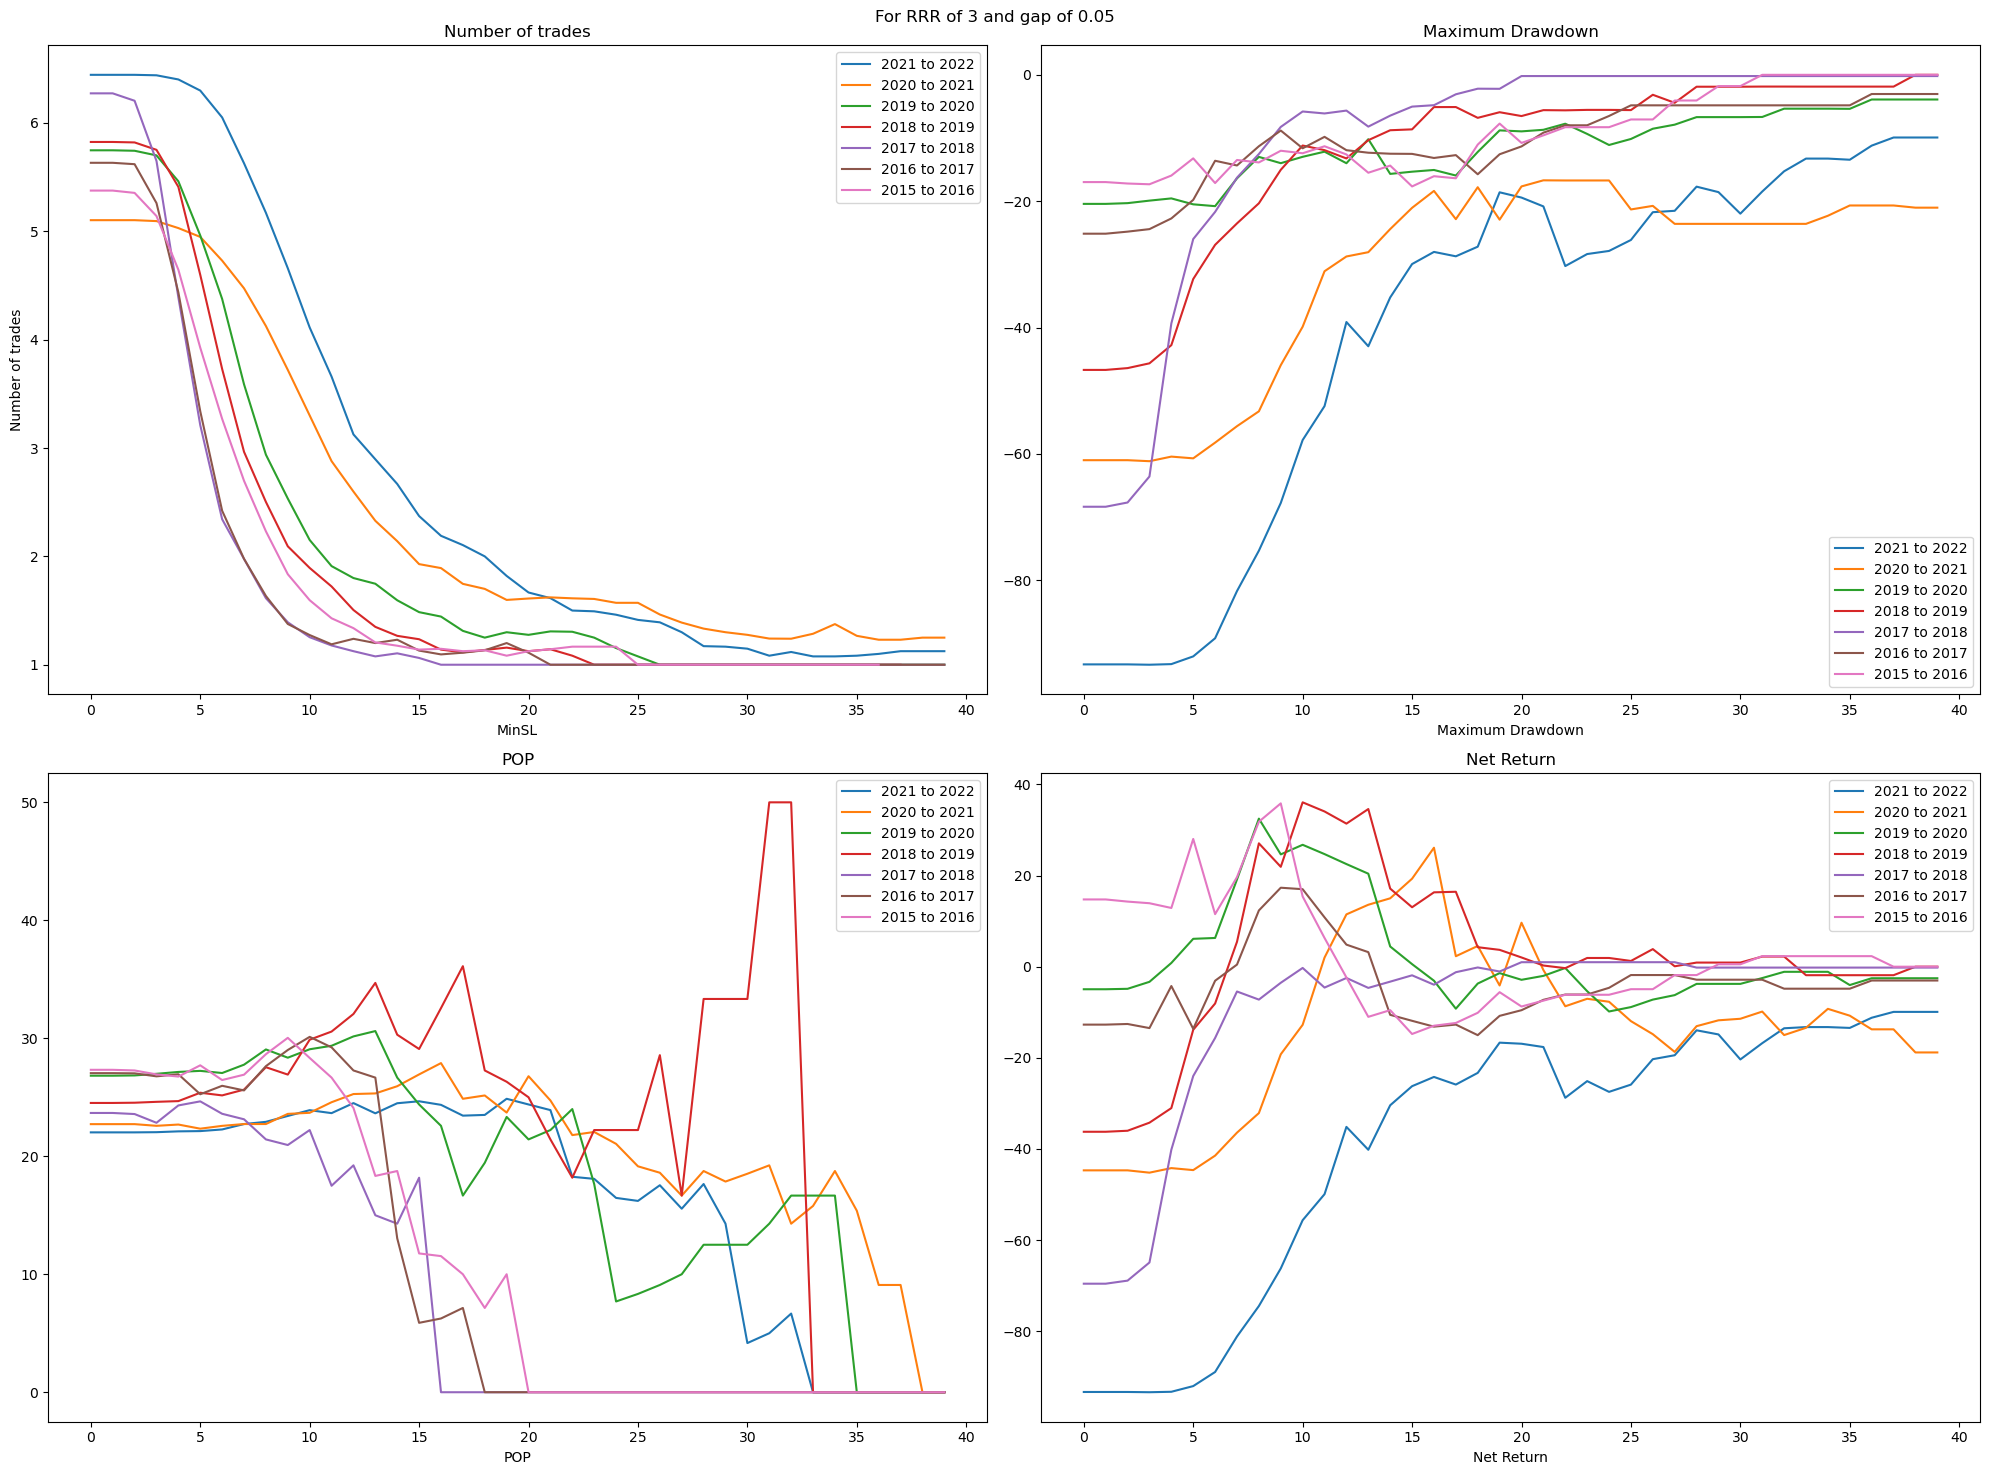

In [110]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
fig.suptitle('For RRR of 3 and gap of 0.05')
ax[0,0].set_xlabel('MinSL')
ax[0,0].set_ylabel('Number of trades')
for j in range(7):
    ax[0,0].plot(c3['MinSL'],d1[j]['Number of trades'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,0].set_title("Number of trades")

ax[0,0].legend()  
ax[0,1].set_xlabel('MinSL')
ax[0,1].set_xlabel('Maximum Drawdown')
for j in range(7):
    ax[0,1].plot(c3['MinSL'],d1[j]['Maximum Drawdown'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,1].set_title("Maximum Drawdown")
    
ax[0,1].legend()
ax[1,0].set_xlabel('MinSL')
ax[1,0].set_xlabel('POP')
for j in range(7):
    ax[1,0].plot(c3['MinSL'],d1[j]['POP'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,0].set_title("POP")
    
ax[1,0].legend()
ax[1,1].set_xlabel('MinSL')
ax[1,1].set_xlabel('Net Return')
for j in range(7):
    ax[1,1].plot(c3['MinSL'],d1[j]['Net Return'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,1].set_title("Net Return")

ax[1,1].legend()
fig.tight_layout()
plt.savefig('Minimum SL Optimization over several years for RRR of 3')

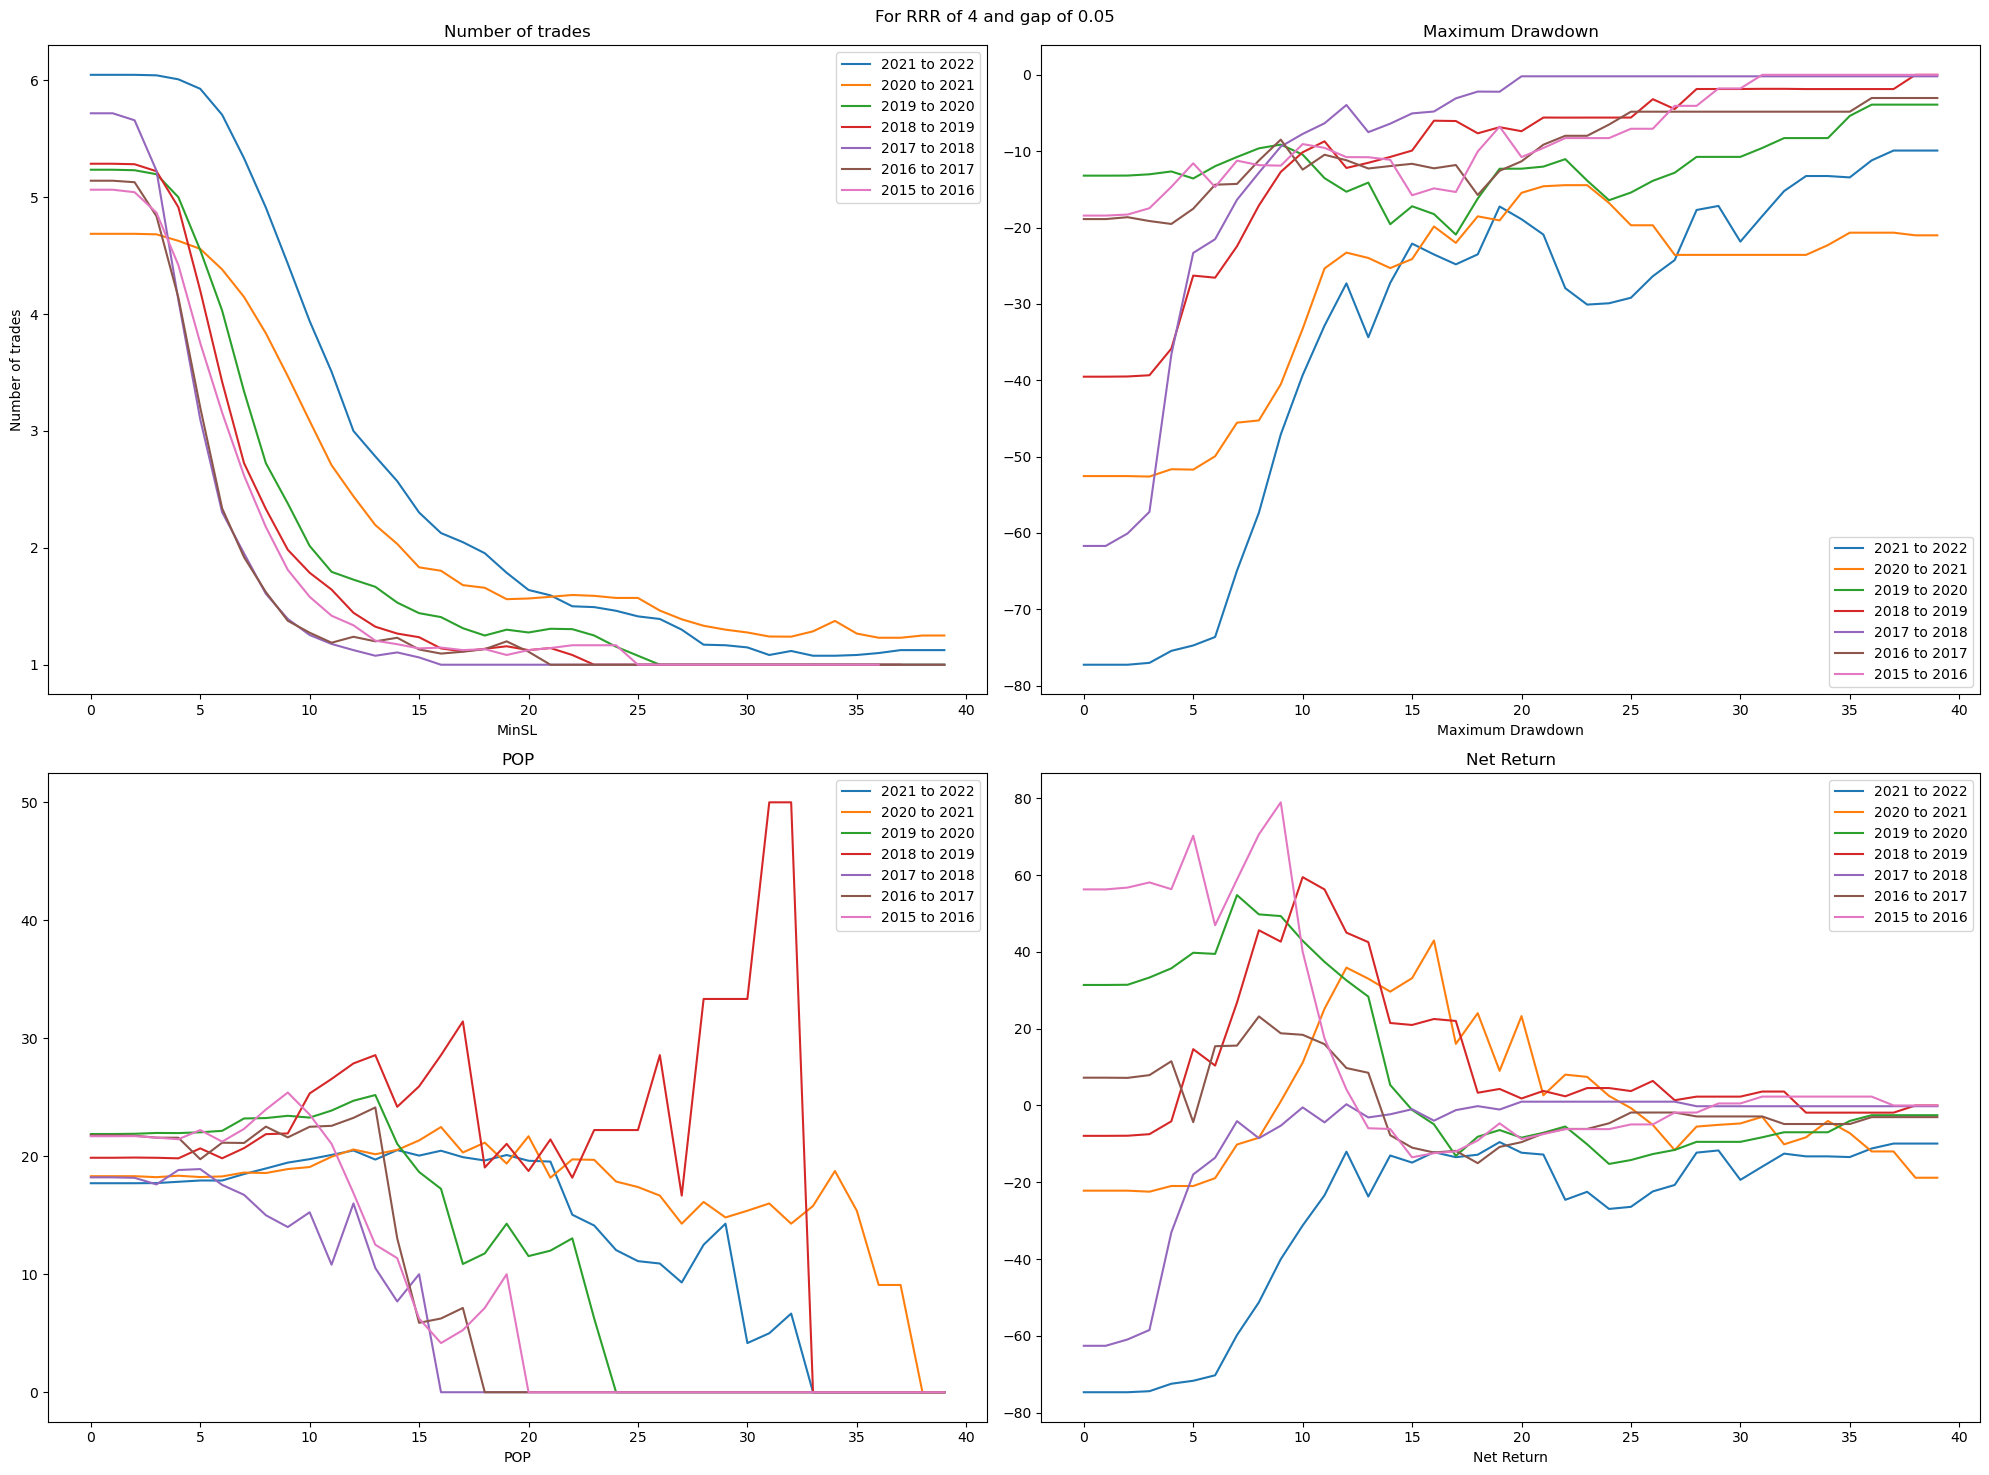

In [108]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
fig.suptitle('For RRR of 4 and gap of 0.05')
ax[0,0].set_xlabel('MinSL')
ax[0,0].set_ylabel('Number of trades')
for j in range(7):
    ax[0,0].plot(c3['MinSL'],d1[j]['Number of trades'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,0].set_title("Number of trades")

ax[0,0].legend()  
ax[0,1].set_xlabel('MinSL')
ax[0,1].set_xlabel('Maximum Drawdown')
for j in range(7):
    ax[0,1].plot(c3['MinSL'],d1[j]['Maximum Drawdown'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[0,1].set_title("Maximum Drawdown")
    
ax[0,1].legend()
ax[1,0].set_xlabel('MinSL')
ax[1,0].set_xlabel('POP')
for j in range(7):
    ax[1,0].plot(c3['MinSL'],d1[j]['POP'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,0].set_title("POP")
    
ax[1,0].legend()
ax[1,1].set_xlabel('MinSL')
ax[1,1].set_xlabel('Net Return')
for j in range(7):
    ax[1,1].plot(c3['MinSL'],d1[j]['Net Return'],label=(dates[1807-d1[j]['LastDate'][0]-234][-4:]+' to '+dates[1807-d1[j]['LastDate'][0]][-4:]))
    ax[1,1].set_title("Net Return")

ax[1,1].legend()
fig.tight_layout()
plt.savefig('Minimum SL Optimization over several years for RRR of 4')

In [ ]:
f=75
plotnifty=nifty5.iloc[a*75:b*75:f, :]
plotnifty.index= pd.to_datetime(plotnifty.Date)
plotnifty.drop('Date',axis=1,inplace=True)
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,7.5))
#plt.yscale("log")
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values,'k',label='EMA Normal')
plt.plot(c2['Balance'][a*75::f].values/25,'b',label='Balance')
#plt.plot(c2['BoughtAt'][a*75::f].values,'g^')
#plt.plot(c2['SoldAt'][a*75::f].values,'rv')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Strategy comparison from '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])
fig.tight_layout()
plt.grid()
plt.legend()
plt.savefig(nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])

In [28]:
c3

,Gap,MinSL,Number of trades,Maximum Drawdown,POP,Net Return,Annualized Return
0,NaN,0,5.32133,-88.988221,19.847151,-58.612684,0.000000
1,NaN,1,5.32133,-88.988221,19.847151,-58.612684,0.000000
2,NaN,2,5.308033,-86.93319,19.844403,-47.969312,0.000000
3,NaN,3,5.178393,-87.553372,19.730407,-51.823254,0.000000
4,NaN,4,4.809867,-64.836037,19.868404,170.501227,13.753394
5,NaN,5,4.301393,-61.056871,19.828089,240.074879,17.175548
6,NaN,6,3.822082,-65.75372,19.618437,133.592183,11.612806
7,NaN,7,3.45565,-44.62842,20.051979,508.195737,26.337069
8,NaN,8,3.153644,-38.630826,20.409134,716.213953,31.242756
9,NaN,9,2.882941,-32.562995,20.627675,811.353701,33.130024


In [29]:
print(c3['Net Return'].values.argmax())
print(c3['Net Return'].values.max())

9
811.3537011904841


In [30]:
c3.iloc[c3['Net Return'].values.argmax()]

Gap                         NaN
MinSL                         9
Number of trades       2.882941
Maximum Drawdown     -32.562995
POP                   20.627675
Net Return           811.353701
Annualized Return     33.130024
Name: 9, dtype: object

In [31]:
c4 = pd.DataFrame(columns=['Date', 'Time','Nifty','Strat','NiftyR','StratR'])
c4['Date'] = nifty5.iloc[a*75::f, :]['Date']
c4['Time'] = nifty5.iloc[a*75::f, :]['Time']
c4['Nifty'] = nifty5.iloc[a*75::f, :]['Close']
c4['Strat'] = c2['Balance'][a*75::f].values
c4.reset_index(inplace=True)
c4.drop('index',axis=1,inplace=True)
c4.at[0,'NiftyR'] = 0
c4.at[0,'StratR'] = 0
for i in range(1,len(nifty5.iloc[a*75::f, :]['Close'])):
    c4.at[i,'NiftyR'] = 100*(c4.loc[i,'Nifty']-c4.loc[i-1,'Nifty'])/c4.loc[i,'Nifty']
    c4.at[i,'StratR'] = 100*(c4.loc[i,'Strat']-c4.loc[i-1,'Strat'])/c4.loc[i,'Strat']
print('Standard Deviation for Nifty: {:.3f} and for Strategy: {:.3f}'.format(c4['Nifty'].std(),c4['Strat'].std()))
print('Standard Deviation of Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c4['NiftyR'].std(),c4['StratR'].std()))
#print('Average Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c4['NiftyR'].mean(),c4['StratR'].mean()))

Standard Deviation for Nifty: 3138.355 and for Strategy: 16213.246
Standard Deviation of Daily Returns for Nifty: 1.212% and for Strategy: 1.035%
